In [ ]:
from utils.preprocessor import *
import contractions
import spacy
from utils.model import Encoder, DecoderAttn
from utils.train import training
from utils.evaluate import evaluateRandom, translate_sentence, calcBLEU
import torch
import torch.nn as nn
from torch import optim

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [21]:
root_path = "../../data/OurDataEn-Vi"
train_data, test_data, val_data = get_dataset("train.txt", root_path=root_path),\
                            get_dataset("test.txt", root_path=root_path),\
                            get_dataset("validation.txt", root_path)
print(train_data, val_data, test_data)

Dataset({
    features: ['en', 'vi'],
    num_rows: 29000
}) Dataset({
    features: ['en', 'vi'],
    num_rows: 1014
}) Dataset({
    features: ['en', 'vi'],
    num_rows: 1000
})


#**Tiền xử lý**#

In [22]:
lst_check = "‘’“”…—"
for char in lst_check:
    for x in train_data['vi']:
        a = x.count(char)
        if a > 0 and a % 2 == 0:
            print(x)
    for x in train_data['en']:
        a = x.count(char)
        if a > 0 and a % 2 == 0:
            print(x)

In [23]:
def update_contractions(text):
    # slang = False !
    return contractions.fix(text, slang=False)
def remove_char_quotes(text):
    rs = text
    cnt1, cnt2 = text.count('"'), text.count("'")
    if cnt1 > 0 and cnt1 % 2 == 0:
        rs = text.replace('"','')
    if cnt2 > 0 and cnt2 % 2 == 0:
        rs = text.replace("'", '')
    return rs
def processing(texts):
    texts['en'], texts['vi'] = [remove_char_quotes(update_contractions(t)).lower().strip() for t in [texts['en'], texts['vi']]]
    return texts
train_data = train_data.map(processing)
test_data = test_data.map(processing)
val_data = val_data.map(processing)

Map: 100%|██████████| 1014/1014 [00:00<00:00, 9856.23 examples/s]


In [15]:
train_data[0]

{'en': 'two young, white males are outside near many bushes.',
 'vi': 'hai thanh niên da trắng ở bên ngoài gần nhiều bụi cây.'}

In [24]:
sos_token = 0
eos_token = 1
unk_token = 2
max_length = 25

In [26]:
en_nlp = spacy.blank("en")
vi_nlp = spacy.blank('vi')

In [30]:
def filter_data(texts):
    return len(en_nlp.tokenizer(texts['en'])) <= max_length and len(vi_nlp.tokenizer(texts['vi'])) <= max_length
train_data = train_data.filter(filter_data)
val_data = val_data.filter(filter_data)
test_data = test_data.filter(filter_data)

Filter: 100%|██████████| 1000/1000 [00:00<00:00, 2405.60 examples/s]


In [31]:
train_data, test_data, val_data

(Dataset({
     features: ['en', 'vi'],
     num_rows: 28181
 }),
 Dataset({
     features: ['en', 'vi'],
     num_rows: 963
 }),
 Dataset({
     features: ['en', 'vi'],
     num_rows: 984
 }))

In [32]:
en_vocab = Vocabulary('en', train_data['en'], en_nlp)
vi_vocab = Vocabulary('vi', train_data['vi'], vi_nlp)

In [33]:
en_vocab.get_index("meomeo")

2

In [34]:
indexesFromSentence(en_vocab, "today meomeo", en_nlp)

[8572, 2]

#**Tham số mô hình**#

In [35]:
hidden_size = 256
batch_size = 128
num_layers = 1
dropout = 0.2
learning_rate = 0.001
num_epochs = 369

In [36]:
train_loader = get_dataloader(train_data, en_vocab, vi_vocab, \
                                    en_nlp, vi_nlp, device, batch_size,\
                                    max_length, 0, 1)

In [25]:
encoder = Encoder(en_vocab.n_words, hidden_size, num_layers, dropout).to(device)
decoder = DecoderAttn(hidden_size, vi_vocab.n_words, device, max_length, 0, 1,2, num_layers, dropout).to(device)

encoder_opt = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_opt = optim.Adam(decoder.parameters(), lr=learning_rate)

criterion = nn.CrossEntropyLoss(ignore_index = 1) # ignore eos_token

In [ ]:
his_loss = training(train_loader, encoder, decoder, encoder_opt, decoder_opt, criterion, num_epochs, 5)

(5 1%) Time: 1m 13s (- 89m 40s) Avg.Loss: 1.84275
(10 2%) Time: 2m 25s (- 86m 56s) Avg.Loss: 0.88780
(15 4%) Time: 3m 36s (- 85m 15s) Avg.Loss: 0.57350
(20 5%) Time: 4m 47s (- 83m 43s) Avg.Loss: 0.40812
(25 6%) Time: 5m 59s (- 82m 33s) Avg.Loss: 0.30847
(30 8%) Time: 7m 12s (- 81m 27s) Avg.Loss: 0.24177
(35 9%) Time: 8m 24s (- 80m 13s) Avg.Loss: 0.19711
(40 10%) Time: 9m 36s (- 78m 57s) Avg.Loss: 0.16224
(45 12%) Time: 10m 47s (- 77m 40s) Avg.Loss: 0.13852
(50 13%) Time: 11m 59s (- 76m 32s) Avg.Loss: 0.11638
(55 14%) Time: 13m 11s (- 75m 19s) Avg.Loss: 0.10129
(60 16%) Time: 14m 23s (- 74m 8s) Avg.Loss: 0.08991
(65 17%) Time: 15m 35s (- 72m 53s) Avg.Loss: 0.07933
(70 18%) Time: 16m 47s (- 71m 43s) Avg.Loss: 0.07243
(75 20%) Time: 18m 0s (- 70m 33s) Avg.Loss: 0.06444
(80 21%) Time: 19m 11s (- 69m 20s) Avg.Loss: 0.05964
(85 23%) Time: 20m 23s (- 68m 6s) Avg.Loss: 0.05491
(90 24%) Time: 21m 34s (- 66m 54s) Avg.Loss: 0.05123
(95 25%) Time: 22m 51s (- 65m 56s) Avg.Loss: 0.04746
(100 27%) Ti

#**Lưu mô hình**#

In [37]:
enc_path = "encoder.pth"
dec_path = "decoder.pth"

In [28]:
torch.save(encoder.state_dict(), enc_path)
torch.save(decoder.state_dict(), dec_path)

In [29]:
enc = Encoder(en_vocab.n_words, hidden_size, num_layers, dropout).to(device)
dec = DecoderAttn(hidden_size, vi_vocab.n_words, device, max_length, 0, 1, 2, num_layers, dropout).to(device)

enc.load_state_dict(torch.load(enc_path, weights_only=True))
dec.load_state_dict(torch.load(dec_path, weights_only=True))

enc.eval()
dec.eval()

DecoderAttn(
  (embedding): Embedding(6067, 256)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=256, out_features=256, bias=True)
    (Ua): Linear(in_features=256, out_features=256, bias=True)
    (Va): Linear(in_features=256, out_features=1, bias=True)
  )
  (lstm): LSTM(512, 256, batch_first=True)
  (out): Linear(in_features=256, out_features=6067, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

#**Trực quan hóa biểu đồ hàm Loss**#

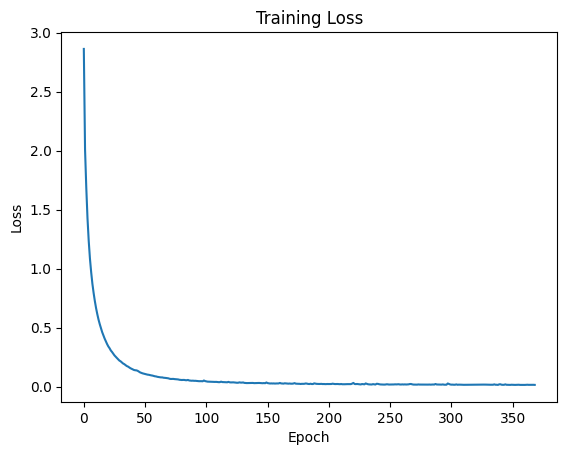

In [ ]:
import matplotlib.pyplot as plt

plt.plot(his_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#**Samples**#

In [31]:
evaluateRandom(enc, dec, train_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 10)

English:	 young person holding a red and black fan in front of a martial arts class.
Vi_true:	 một thanh niên cầm một chiếc quạt màu đỏ và đen trước một lớp học võ thuật.
Vi_pred:	 một thanh niên cầm một chiếc quạt màu đỏ và đen trước một lớp học võ thuật . . noble . noble . noble . noble . noble
------------
English:	 colorful yellow seats with a sparse crowd line up behind four soccer players trying to go after a ball.
Vi_true:	 những chiếc ghế màu vàng sặc sỡ với đám đông thưa thớt xếp hàng sau bốn cầu thủ bóng đá đang cố gắng đuổi theo một quả bóng.
Vi_pred:	 mặt trên ghế màu vàng sặc sỡ với đám đông thưa thớt xếp hàng sau bốn cầu thủ bóng đá đang cố gắng đuổi theo một quả bóng . . .
------------
English:	 a man in a doctors coat emerges from a building.
Vi_true:	 một người đàn ông mặc áo khoác bác sĩ xuất hiện từ một tòa nhà.
Vi_pred:	 một người đàn ông mặc áo khoác bác sĩ xuất hiện từ một tòa nhà . tòa nhà . . ` . .
------------
English:	 a man with a lot of jewelry and punk rock

In [32]:
evaluateRandom(enc, dec, val_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 10)

English:	 a woman hanging from a tree, her leg wrapped in cloth.
Vi_true:	 một người phụ nữ treo mình trên cây, chân quấn vải.
Vi_pred:	 một người phụ nữ treo mình trên một cái cây , chân giơ mặc vải . . .
------------
English:	 a group of friends lay sprawled out on the floor enjoying their time together.
Vi_true:	 một nhóm bạn nằm dài trên sàn tận hưởng khoảng thời gian bên nhau.
Vi_pred:	 một nhóm bạn nằm dài trên sàn được tận hưởng thời gian . noble . noble . noble . noble . noble . noble . noble .
------------
English:	 a group of parents are sitting at an outdoor assembly.
Vi_true:	 một nhóm phụ huynh đang ngồi trong một cuộc họp ngoài trời.
Vi_pred:	 một nhóm người lớn đang ngồi ở một bữa ngoài trời đông đúc . ngoài trời .
------------
English:	 a young boy in yellow t-shirt hanging from a ring with other kids around.
Vi_true:	 một cậu bé mặc áo phông màu vàng đang treo mình trên một chiếc vòng với những đứa trẻ khác xung quanh.
Vi_pred:	 một cậu bé mặc áo phông vàng treo mình t

In [35]:
inp_texts = ['people wearing the dirty jeans and riding a bicycle together']
translate_sentence(enc, dec, inp_texts, en_vocab, vi_vocab, en_nlp, device)

['mặc quần jean , áo sơ mi và cùng nhau đi xe đạp cùng nhau . ` .']

In [36]:
evaluateRandom(enc, dec, val_data, en_vocab, vi_vocab, en_nlp, vi_nlp, device, 5)

English:	 two little girls in blue dresses laugh.
Vi_true:	 hai bé gái mặc váy xanh cười.
Vi_pred:	 hai bé mặc váy xanh cười . cười . châu á .
------------
English:	 a woman who is wearing white shorts, yellow top and white sandals appears to be throwing a stick.
Vi_true:	 một người phụ nữ mặc quần đùi trắng, áo vàng và dép xăng đan trắng dường như đang ném một cây gậy.
Vi_pred:	 một người phụ nữ mặc quần đùi trắng , áo vàng và giày thể thao dường như đang ném một cây gậy . . .
------------
English:	 a man wearing goggles exits a pool by the ladder.
Vi_true:	 một người đàn ông đeo kính bảo hộ bước ra khỏi hồ bơi bằng thang.
Vi_pred:	 một người đàn ông đeo kính bảo hộ bước ra khỏi hồ bơi bên cạnh đường ray . thang . `
------------
English:	 here is a picture of a teenager trimming his brother's head hair.
Vi_true:	 đây là hình ảnh một thiếu niên đang cắt tóc cho anh trai mình.
Vi_pred:	 khoảng hình ảnh từ anh trai đang cắt tóc . mình . com . .
------------
English:	 a bicyclist is doing

In [34]:
calcBLEU(enc, dec, test_data,  en_vocab, vi_vocab, en_nlp, vi_nlp, device)

0.35866784119535605